## Assignment 1: E-Car
The objective of this assigment is to analize the "e-car data" in order to find a method to improve expected profits

#### Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import style
import matplotlib.ticker as mticker
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
#from sckit import optimization

#### Loading the data

In [2]:
d_raw = pd.read_excel('PY_DATA.xlsx', skiprows = 1)
d_raw.sample(5)

,Tier,FICO,Approve_Date,Term,Amount,Previous Rate,Car Type,Competition Rate,Outcome,Rate,Partner
196,1,778,2004-09-01,36,5709.79,9.50,R,4.99,1,4.99,1
824,1,790,2003-08-18,36,18795.00,7.25,R,4.99,1,4.99,3
1602,1,732,2004-02-20,36,6166.00,5.90,R,4.75,1,4.75,1
4063,1,773,2004-04-29,36,10567.00,7.90,R,4.65,1,4.45,3
3827,1,758,2003-06-17,36,9050.00,8.75,R,4.39,1,4.48,1


#### Data cleaning and feature engineering

We will drop uninformative features that present no variance in the dataset. Those are "Car Type", "Term", and "Tier". Then we split the dataset in training data and test data using sklearn.model_selection. We take 70% 30%(Using a wildly spread rule of thumb). It is true that we should split the data in train, dev and test sets in order to have unbiased test results. Since we do not have enough data to do so we stick with the common train/test separation. Finally we regularize our input features.

In [3]:
d_raw.drop(columns={'Tier', 'Term','Car Type','Approve_Date'},inplace= True)

In [4]:
train , test = train_test_split(d_raw, test_size=0.3)
datasets = [train.copy(),test.copy()]
X_train = datasets[0].drop(columns={'Outcome'})
X_test = datasets[1].drop(columns={'Outcome'})
Y_train = datasets[0]['Outcome']
Y_test = datasets[1]['Outcome']
#Generate several copies of the imput features to try different combinations of raw data + augmented data
X_s = [X_train,X_test] #Original
X_s1 = [X_train.copy(),X_test.copy()]
X_s2 = [X_train.copy(),X_test.copy()]
X_s3 = [X_train.copy(),X_test.copy()]
X_s[0].head()

,FICO,Amount,Previous Rate,Competition Rate,Rate,Partner
5306,773,19500.0,9.0,4.39,4.39,2
5886,804,14000.0,6.0,4.75,4.25,1
1243,730,11400.0,7.5,4.75,4.89,1
4632,762,10300.0,5.0,4.39,4.39,3
4068,742,10700.0,9.9,4.45,4.45,3


#### Feature engineering
* For X_s1 we assume that the potential buyer cares about how much it can save (maybe it is not worth to go trough the process of changing your loan if the expected saving is 10$). Moreover we assume that the buyer knows the competition rate and compares the amount saved if he buys to us and the amount saved when he buys to our competitors. Finally we create a dummy that takes value 1 when our rate is the lowest and an interaction between rate and partner.
* In X_2 we simply take all the interaction terms of the raw data.
* X_3 take all interactions of X_s1 -> we do not care about causality of other variables other than Rate (since we cannot control them) and all Rate interactions could have a reasonable explanation.

In [5]:
for imput_f in X_s1:
    imput_f['Saving_Buy'] = imput_f['Amount']*((imput_f['Previous Rate']-imput_f['Rate'])/100)
    imput_f['Saving_Comp'] = imput_f['Amount']*((imput_f['Previous Rate']-imput_f['Competition Rate'])/100)
    imput_f['Best_rate'] = imput_f['Rate'] <= imput_f['Competition Rate'] #and imput_f['Rate'] < ['Previous Rate'])*1
    imput_f['Rate_Partner'] = imput_f['Rate']*imput_f['Partner']
#X_s2
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_s2[0] = poly.fit_transform(X_s[0])
X_s2[1] = poly.fit_transform(X_s[1])
X_s2_labels = poly.fit(X_s[0]).get_feature_names(X_s[0].columns)
X_s2[0] = pd.DataFrame(X_s2[0]) 
X_s2[1] = pd.DataFrame(X_s2[1]) 
#X_s3
X_s3[0] = poly.fit_transform(X_s1[0]) 
X_s3[1] = poly.fit_transform(X_s1[1])
X_s3_labels = poly.fit(X_s1[0]).get_feature_names(X_s1[0].columns)
X_s3[0] = pd.DataFrame(X_s3[0]) 
X_s3[1] = pd.DataFrame(X_s3[1]) 

#### Looking at correlations heatmap for X_s

[Text(0,0.5,'FICO'),
 Text(0,1.5,'Amount'),
 Text(0,2.5,'Previous Rate'),
 Text(0,3.5,'Competition Rate'),
 Text(0,4.5,'Rate'),
 Text(0,5.5,'Partner')]

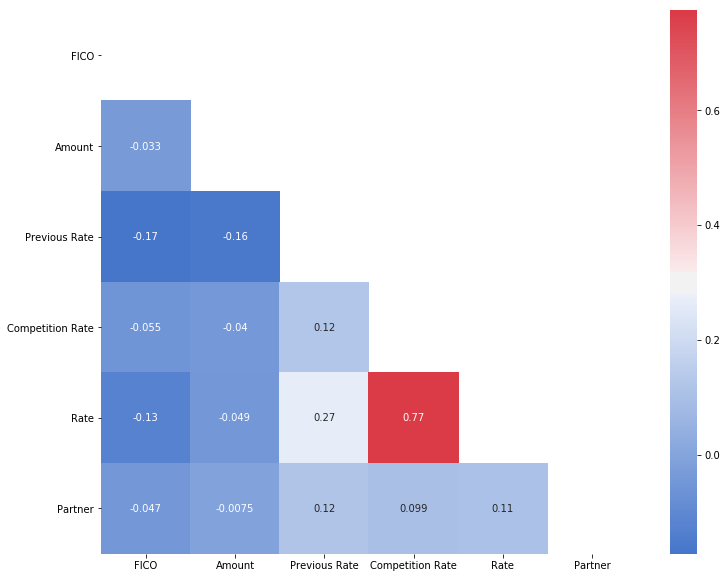

In [6]:
mdata = X_s[0].corr()
mdata = mdata.where(mdata != 1)
mask = np.zeros_like(mdata, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(255,10, as_cmap=True)
fig = plt.figure(figsize=(12,10)) 
hmap = sns.heatmap(mdata,annot=True, mask = mask, cmap=cmap, vmax = mdata.max().max(),vmin = mdata.min().min())
hmap.set_yticklabels(hmap.get_yticklabels(), rotation = 0)

#### X regularization

In [7]:
def X_reg(X):
    for label in X.columns:
        MEAN = (X[label] - X[label].mean())
        VAR = (1/X.shape[0])*np.sum(np.power(X[label],2))
        X[label] = MEAN/np.sqrt(VAR)

In [8]:
X_reg(X_s[0])
X_reg(X_s[1])
X_reg(X_s1[0])
X_reg(X_s1[1])
X_reg(X_s2[0])
X_reg(X_s2[1])
X_reg(X_s3[0])
X_reg(X_s3[1])

## Classification models

#### Logit Model

In [9]:
def logit_max_in(X,Y):
    B = np.random.randn(X.shape[1],1)*0.001 #(nx,1)
    A = 0
    X = X.T #(nx,m)
    Y = Y.values.reshape(1,4344) #(1,m)
    m = len(Y.T)
    return B , A , X , Y , m
def for_back(X,Y,B,A,m):
    #Linear step
    Z = np.dot(B.T,X)+A #(1,nx)(nx,m) = (1,m)
    #Sigmoid
    S = 1/(1+np.exp(Z)) #(1,m)
    cost = (1/m)*np.sum(-(Y*np.log(S)+(1-Y)*np.log(1-S)))
    #Back
    dZ = Y - S #(1,m)
    dA = (1/m)*np.sum(dZ)
    dB = (1/m)*np.dot(X,dZ.T)
    return dA , dB , cost , S

* Gradient descent

In [10]:
def model(X,Y):
    B, A, X , Y , m = logit_max_in(X,Y)
    costs = []
    for i in range(300000):
        dA , dB, cost , S = for_back(X,Y,B,A,m)
        B = B - 0.01*dB
        A = A - 0.01*dA
        if i % 50000 == 0:
                costs.append(cost)
        if i % 50000 == 0:
                print ("Cost after iteration %i: %f" %(i, cost))
    return A , B

In [11]:
A , B = model(X_s[0],Y_train)

Cost after iteration 0: 0.693113
Cost after iteration 50000: 0.669698
Cost after iteration 100000: 0.669256
Cost after iteration 150000: 0.668956
Cost after iteration 200000: 0.668736
Cost after iteration 250000: 0.668570


In [12]:
#With sklearn (comprovation)
logisticRegr = LogisticRegression()
model = logisticRegr.fit(X_s[0], Y_train)
sklearnmodel = pd.DataFrame(model.predict_proba(X_s[0]))
def probabilities_pred(X,B,A):
    Z = np.dot(B.T,X.T)+A
    S = 1/(1+np.exp(Z))
    return pd.DataFrame(S)
pred_grad = probabilities_pred(X_s[0],B,A)
sklearnmodel['grad'] = pred_grad.T
sklearnmodel.head()

,0,1,grad
0,0.673600,0.326400,0.323339
1,0.626444,0.373556,0.370811
2,0.477854,0.522146,0.524768
3,0.608771,0.391229,0.389358
4,0.483603,0.516397,0.515620


* Personal use code

In [13]:
# from IPython.display import HTML
# import base64  
# def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
#     csv = df.to_csv()
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)

# create_download_link("DATAFRAME THAT I WANT TO EXPORT)

####  Clustering

* KMeans

5 seems to perform well

In [14]:
km_data = d_raw.copy().drop(columns = {'Outcome'})
X_reg(km_data)
X_4_1 = d_raw.copy()
cluster = KMeans(n_clusters=5, random_state =0)
X_4_1['Cluster'] = cluster.fit_predict(km_data)

Split train/test

In [15]:
train4 , test4 = train_test_split(X_4_1, test_size=0.3)
Y_test_k = test4.copy()['Outcome']
Y_train_k = train4.copy()['Outcome']
test_X_k = test4.drop(columns={'Outcome'})
train_X_k = train4.drop(columns={'Outcome'})
X_s4 = [train_X_k.copy(),test_X_k.copy()]

In [16]:
X_reg(X_s4[0])
X_reg(X_s4[1])

* Representation

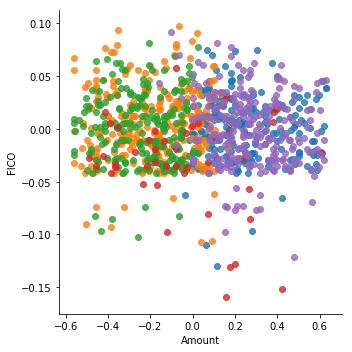

In [17]:
ploting1 = X_s4[0].copy()
model0 = logisticRegr.fit(ploting1, Y_train_k)
probs = pd.DataFrame(model0.predict_proba(ploting1)).drop(columns={0})
ploting1['probs'] = probs
sns.lmplot(x='Amount', y='FICO',data=ploting1.sample(1000),fit_reg=False, hue ='Cluster', legend=False) 

* Hierarchical cluster analysis: AgglomerativeClustering: 10 clusters

In [18]:
km_data = d_raw.copy().drop(columns = {'Outcome'})
X_reg(km_data)
X_5_1 = d_raw.copy()
cluster = AgglomerativeClustering(n_clusters=10)
X_5_1['Cluster'] = cluster.fit_predict(km_data)
cluster_models5 = pd.DataFrame([0])

In [19]:
train5 , test5 = train_test_split(X_5_1, test_size=0.3)
Y_test_a = test5.copy()['Outcome']
Y_train_a = train5.copy()['Outcome']
test_X_k = test5.drop(columns={'Outcome'})
train_X_k = train5.drop(columns={'Outcome'})
X_s5 = [train_X_k.copy(),test_X_k.copy()]

In [20]:
X_reg(X_s5[0])
X_reg(X_s5[1])

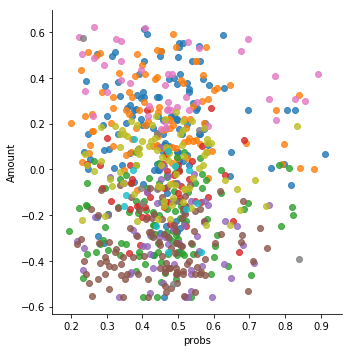

In [21]:
ploting1 = X_s5[0].copy()
model0 = logisticRegr.fit(ploting1, Y_train_a)
probs = pd.DataFrame(model0.predict_proba(ploting1)).drop(columns={0})
ploting1['probs'] = probs
sns.lmplot(x='probs', y='Amount',data=ploting1.sample(1000),fit_reg=False, hue ='Cluster', legend=False) 

#### Models performance (% of correct predictions) SCORE ES COST O %?
Using sklearn (very similar results to the "hard coded" implementation)

In [22]:
model0 = logisticRegr.fit(X_s[0],Y_train)
print('model  0' + '  ' + str(model0.score(X_s[1],Y_test)))
model1 = logisticRegr.fit(X_s1[0],Y_train)
print('model  1' + '  ' + str(model1.score(X_s1[1],Y_test)))
model2 = logisticRegr.fit(X_s2[0],Y_train)
print('model  2' + '  ' + str(model2.score(X_s2[1],Y_test)))
model3 = logisticRegr.fit(X_s3[0],Y_train)
print('model  3' + '  ' + str(model3.score(X_s3[1],Y_test)))
model4 = logisticRegr.fit(X_s4[0],Y_train_k)
print('model  4' + '  ' + str(model3.score(X_s4[1],Y_test_k)))
model4 = logisticRegr.fit(X_s5[0],Y_train_a)
print('model  5' + '  ' + str(model3.score(X_s5[1],Y_test_a)))

model  0  0.5880773361976369
model  1  0.5902255639097744
model  2  0.5945220193340494
model  3  0.6063372717508055
model  4  0.5800214822771214
model  5  0.5859291084854995


#### Distribution of the data (predicted probabilities of the simple model) 

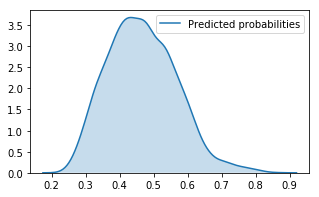

In [23]:
#Predicted probabilities
model0 = logisticRegr.fit(X_s[0], Y_train)
fig =plt.figure(figsize=(5,3))
sns.kdeplot(pd.DataFrame(model0.predict_proba(X_s[0]))[1], shade = True, label = 'Predicted probabilities')

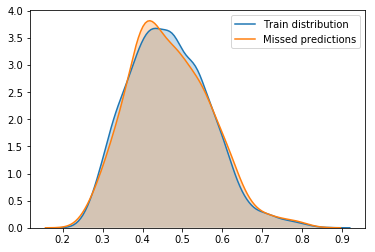

In [24]:
#Predictions vs Wrong predictions dis considering P>0.5 -> =1; 0 otherwise
probas = pd.DataFrame(model0.predict_proba(X_s[0]))
sns.kdeplot(probas[1], shade = True, label = 'Train distribution')
wrong = (model0.predict(X_s[0]) != Y_train)*1
sns.kdeplot(probas[1].where(wrong ==1).dropna(), shade = True, label = 'Missed predictions')

### Neural network (it is clear that we do not have the amount of data in order to obtain differentially good results with this method, however, I wanted to practice what I learnt in Ng Andrew's course)

In [25]:
Xtr = X_train.T
Ytr = Y_train.values.reshape(1,4344)
Xts = X_test.T
Yts = Y_test.values.reshape(1,Y_test.shape[0])

In [26]:
#L layer initialization function
def l_initialization(list_dims): #list_dims = [n_x,n_1,...,n_L]
    parameter = {} #create a dictionary to store our parameters in it
    nplus_layer = len(list_dims) #assessing the number of layers in the network + the imput feature "layer"
    for i in range (1,nplus_layer):
        parameter['W' + str(i)] = np.random.randn(list_dims[i],list_dims[i-1])*0.01
        parameter['b' + str(i)] = np.zeros((list_dims[i],1)) #don't need to use (n_l+1,m) for posterior vectorization because of broadcasting
    return parameter

In [27]:
#L layer forward propagation (considering last layer always uses sigmoid)  
def l_forward_prop(X,parameter,Y): #X is imput features, parameter are the parameters and activation is relu or tanh
    cache_A = [] #opening list to store cache for use in backprop
    cache_Z = [] #same
    l_num = int(len(parameter)/2) #Number of layers in the NN
    A = X
    m = X.shape[1]
    #tanh middle layers
    for i in range (1,l_num): #loop to calculate forward prop for each layer
        Z = np.dot(parameter['W' + str(i)],A) + parameter['b'+str(i)]
        cache_Z.append(Z)
        A = np.tanh(Z)
        cache_A.append(A)
    #Sigmoid last layer
    Z = np.dot(parameter['W' + str(l_num)],A) + parameter['b'+str(l_num)] #last layer sigmoid
    cache_Z.append(Z)
    A = (1/(1+np.exp(-Z)))
    cache_A.append(A)
    cost = -(1/m)*np.sum(Y*np.log(cache_A[l_num-1])+(1-Y)*np.log(1-cache_A[l_num-1]))
    
    return cache_Z , cache_A , cost

In [28]:
#L layer backward propagation
def l_back_prop(cache_Z,cache_A,parameters,X,Y):
    L = len(cache_Z) #Number of layers
    grads = {}
    m = cache_A[L-1].shape[1]
    
    #SIGMOID LAYER
    grads['dZ'+str(L)] = cache_A[L-1] - Y # per la ultima layer
    grads['dW'+str(L)] = (1/m)*np.dot(grads['dZ'+str(L)],cache_A[L-1].T)
    grads['db'+str(L)] = (1/m)*np.sum(grads['dZ'+str(L)], axis = 1, keepdims = True)
    #Tanh layers
    for i in range(L-1,0,-1):
        if i-2 >= 0:
            grads['dZ'+str(i)] = np.dot(parameters['W'+str(i+1)].T,grads['dZ'+str(i+1)])*(1-np.power(cache_A[i-1],2))
            grads['dW'+str(i)] = (1/m)*np.dot(grads['dZ'+str(i)],cache_A[i-2].T)
            grads['db'+str(i)] = (1/m)*np.sum(grads['dZ'+str(i)],axis=1,keepdims=True)
        else:
            grads['dZ'+str(i)] = np.dot(parameters['W'+str(i+1)].T,grads['dZ'+str(i+1)])*(1-np.power(cache_A[i-1],2))
            grads['dW'+str(i)] = (1/m)*np.dot(grads['dZ'+str(i)],X.T)
            grads['db'+str(i)] = (1/m)*np.sum(grads['dZ'+str(i)],axis=1,keepdims=True)
    return grads

In [29]:
#DESCENT
dimensions = [6,3,1]
parameters = l_initialization(dimensions)
nplus_layer = len(dimensions)
costs = []
for x in range(50000):
    cache_Z , cache_A, cost = l_forward_prop(Xtr,parameters,Ytr)
    grads = l_back_prop(cache_Z,cache_A,parameters,Xtr,Ytr)
    for i in range (1,nplus_layer):
        parameters['W' + str(i)] = parameters['W' + str(i)] - 0.001*grads['dW' + str(i)]
        parameters['b' + str(i)] = parameters['b' + str(i)] - 0.001*grads['db' + str(i)]
    if x % 5000 == 0:
            costs.append(cost)
    if x % 5000 == 0:
            print ("Cost after iteration %i: %f" %(x, cost))

Cost after iteration 0: 0.693151
Cost after iteration 5000: 0.690989
Cost after iteration 10000: 0.690759
Cost after iteration 15000: 0.690683
Cost after iteration 20000: 0.690621
Cost after iteration 25000: 0.690561
Cost after iteration 30000: 0.690503
Cost after iteration 35000: 0.690447
Cost after iteration 40000: 0.690393
Cost after iteration 45000: 0.690341


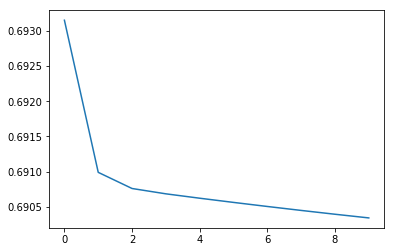

In [30]:
plt.plot(np.squeeze(costs))

In [31]:
# #Accuracy on test
# X1 = datasets[1].drop(columns=['Outcome']).T
# Y1 = datasets[1]['Outcome'].values.reshape(1,datasets[1].shape[0])
# for label in X1.index:
#     MEAN = (X1.loc[label] - X1.loc[label].mean())
#     VAR = (1/m)*np.sum(np.power(X1.loc[label],2))
#     X1.loc[label] = MEAN/np.sqrt(VAR)
# #Test
# Y_Hat = (1/(1+np.exp(A+np.dot(B.T,X1))))
Y_prediction = np.zeros((1,len(Yts.T)))
cache_Z , cache_A, cost = l_forward_prop(Xts,parameters,Yts)

Y_Hat = cache_A[1]
for i in range(0,len(Yts.T)-1):
    if Y_Hat[0,i] > 0.5:
        Y_prediction[0,i] = 1
    if Y_Hat[0,i] <= 0.5:
        Y_prediction[0,i] = 0
#%Accuracy
Accuracy = np.equal(Y_prediction,Yts)*1
print(str(np.sum(Accuracy)/len(Yts.T)))

0.5349087003222341


## CONCLUSION AND PROFIT MAXIMIZATION PROBLEM

* After trying several combinations to maximize profit I come to an expected conclusion. The methods used are not suitable for the problem. The methods used are relatively good at predicting in sample outcome given a training and a test sets. However, when we maximize profit we encounter out of sample interest rate on the loans. The problem is that the data has almost no variance if we compare the dummies rate better than competitor and rate better than previous rate. This leads to little predictive power (in sample) of the variable rate which in turn leads to huge rates when maximizing profits.
* If we want to maximize profits we should take a simpler approach using 1 or 2 more variables besides rate at most (or a combination of other variables through feature engineering). This will lead to more reasonable results. 